### Contributors: Andrew Bumgardner, Quinn Carmack, Erez Keler, Asher Weiman

### Introduction

This tutorial will take you through the data science pipeline, of which there are five steps: 
1.    Data collection
2.    Data processing
3.    Exploratory analysis & data visualization
4.    Analysis, hypothesis testing & ML
5.    Insight & Policy decision
The topic we have chosen to highlight and run through this process is United States wildfires. This is an example of a prevalent issue that affects thousands of acres of land every year. They contribute to climate change and pose a threat to the health of human beings as outlined by the [World Health Organization](https://www.who.int/health-topics/wildfires#tab=tab_1). Since human lives, as well as the environment are largely impacted by wildfires, it is important to measure them via data science to aid in policy decisions. By analyzing past wildfire data, we can look at when they are most likely to occur throughout the year, the rate at which wildfire occurrences have been increasing, and we can look at what features of wildfires might allow us to predict the characteristics of future wildfires.  

### Data Collection

The first phase when moving through the data science pipeline is collecting data. We have chosen a dataset containing information about 1.88 million United States wildfires located [here](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires). The data is organized as an SQLite file. Downloading the SQLight file from the website entitled `FPA_FOD_20170508.sqlite` and placing it within the same folder as the file you will be coding in, will allow us to easily take advantage of coding libraries to access the data.

Note that when you download the data from the website, it may download as a zip file. If it does, then you will have to unzip the zip file and extract its content, `FPA_FOD_20170508.sqlite` into the same folder as this one.

For this particular project, we will be using the Python programming language alongside Jupyter Notebooks to organize and run our code. More information on [Python](https://www.python.org) can be found on its home page, while more information on the basics of jupyter notebooks can be found [here](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html).

The imported libraries we will be utilizing to perform our data analysis are as follows:

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import scipy

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



If any of the above modules causes an error when running on a personal device, it may be necessary to run 'pip install [module name]' in a Terminal window on your machine.

Additionally, shown below, is the code for accessing the dataset we will be analyzing and storing the desired columns in a Pandas dataframe. Pandas is a python library that we will be working with quite closely throughout this project, as it allows us to store, manipulate, access, and transform all of the data from the SQLite files with built in functions. An article detailing getting started with pandas can be found [here](https://pandas.pydata.org/getting_started.html).

The table contains a lot of data, but we are only interested in some of features. Since we are trying analyze wildfires, where and why the occur, we have compiled a list of features are particularly of interest to us:

* discovery_date (start_date): The date at which the wildfire was found/reported by someone
* cont_date (end_date): The date at which the wildfire was controlled/ended
* latitude: Latitude coordinate of the fire
* longitude: Longitude coordinate of the fire
* state: The two letter state abbreviation at where the fire occurred
* stat_cause_code: The suspected reason of why the fire started. Each code corresponds to a reason, such as a human cause or natural.
* fire_size: The total acre burning coverage of the wildfire

In [23]:
# Connect to the file which contains our SQLite information

file = 'FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(file)

# Pull out the data we are interested in.
data_query = '''select discovery_date as start_date, cont_date as end_date,
    latitude, longitude, state, stat_cause_code,
    fire_size from fires;'''

# Convert the results from the query into a pandas dataframe
fire_data = pd.read_sql(data_query, conn)


The columns we are interested in examining are written in our SQL query and shown atop the snippet of our dataframe, displaying the top 10 entries of the table. Other code featured before displaying the table snippet shows the first of many transformations we will make on our dataframe. We are converting the given dates by the table into [pandas datetime objects](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) that will be easier to manipulate throughout the project.

In [24]:
# The date in the dataset is using the Julian Calendar date. To convert this
# over to the regular datetime we are familiar with, we use the pandas libary
# to do the conversion.
epoch = pd.to_datetime(0, unit='s').to_julian_date()

# Both the start_date and end_date of the fire must be converted.
fire_data['start_date'] = pd.to_datetime(fire_data['start_date'] - epoch, unit='D')
fire_data['end_date'] = pd.to_datetime(fire_data['end_date'] - epoch, unit='D')
fire_data.head(10)

,start_date,end_date,LATITUDE,LONGITUDE,STATE,STAT_CAUSE_CODE,FIRE_SIZE
0,2005-02-02,2005-02-02,40.036944,-121.005833,CA,9.0,0.10
1,2004-05-12,2004-05-12,38.933056,-120.404444,CA,1.0,0.25
2,2004-05-31,2004-05-31,38.984167,-120.735556,CA,5.0,0.10
3,2004-06-28,2004-07-03,38.559167,-119.913333,CA,1.0,0.10
4,2004-06-28,2004-07-03,38.559167,-119.933056,CA,1.0,0.10
5,2004-06-30,2004-07-01,38.635278,-120.103611,CA,1.0,0.10
6,2004-07-01,2004-07-02,38.688333,-120.153333,CA,1.0,0.10
7,2005-03-08,2005-03-08,40.968056,-122.433889,CA,5.0,0.80
8,2005-03-15,2005-03-15,41.233611,-122.283333,CA,5.0,1.00
9,2004-07-01,2004-07-02,38.548333,-120.149167,CA,1.0,0.10


### Data Processing
Now that we have our data collected and displayed in a clear fashion, we can begin performing more transformations on our data frame that will be helpful for analysis.

The next very important part of data collection is removing any bad values. As seen above, there are some rows (namely rows 7 and 8) that have "None" for the column County. This could have occurred for a number of reasons when the data was being collected. Whatever the reason, that data is just not available. To remedy this, we will remove any rows/entries that have "None" for any of the columns. This ensures that all the entries we examine are complete with data.

The data in the table ranges from 1992 to 2015. We will just work with data from 1995 to 2015. This way, we can examine wildfire data every five years and the data will split evenly. 

In [25]:
# Here we strip out any rows that have null for any of the columns.
fire_data = fire_data[~fire_data["start_date"].isnull()]
fire_data = fire_data[~fire_data["end_date"].isnull()]
fire_data = fire_data[~fire_data["LATITUDE"].isnull()]
fire_data = fire_data[~fire_data["LONGITUDE"].isnull()]
fire_data = fire_data[~fire_data["STATE"].isnull()]
fire_data = fire_data[~fire_data["STAT_CAUSE_CODE"].isnull()]
fire_data = fire_data[~fire_data["FIRE_SIZE"].isnull()]

# We only want to keep years 1995 - 2015, so we extract out all the data whose
# start date is after January 1st, 1995.
fire_data = fire_data[fire_data['start_date'] >= '1995-01-01']
# Later, we will make graphs of the data every five years. So, we want to
# classify each entry in one of 4 "bins" where each bin is a range of years.
# This way, we can just extract the data by bins, and it will represent being
# in time range.
fire_data['bins'] = pd.cut(fire_data['start_date'], 4,
    labels=[ '1995 - 1999', '2000 - 2004', '2005 - 2009', '2010 - 2015' ])
fire_data.sort_values('start_date').head()

# We also later want to plot the data by year and by month, so it's useful to
# make a year and month column to do so. We extract the month and year from the
# start date, and put it into its own column feature. This way, we can easily
# access all the data of a certain month or year.
months = []
years = []

for index, row in fire_data.iterrows():
    month = row['start_date'].month
    year = row['start_date'].year
    months.append(month)
    years.append(year)

fire_data['start_month'] = months
fire_data['start_year'] = years

display(fire_data)


,start_date,end_date,LATITUDE,LONGITUDE,STATE,STAT_CAUSE_CODE,FIRE_SIZE,bins,start_month,start_year
0,2005-02-02,2005-02-02,40.036944,-121.005833,CA,9.0,0.10,2000 - 2004,2,2005
1,2004-05-12,2004-05-12,38.933056,-120.404444,CA,1.0,0.25,2000 - 2004,5,2004
2,2004-05-31,2004-05-31,38.984167,-120.735556,CA,5.0,0.10,2000 - 2004,5,2004
3,2004-06-28,2004-07-03,38.559167,-119.913333,CA,1.0,0.10,2000 - 2004,6,2004
4,2004-06-28,2004-07-03,38.559167,-119.933056,CA,1.0,0.10,2000 - 2004,6,2004
...,...,...,...,...,...,...,...,...,...,...
1880456,2015-06-14,2015-06-14,40.019907,-122.391398,CA,13.0,2.22,2010 - 2015,6,2015
1880457,2015-09-30,2015-10-01,40.588583,-123.069617,CA,7.0,1.00,2010 - 2015,9,2015
1880458,2015-08-01,2015-08-06,40.244833,-123.544167,CA,1.0,4.00,2010 - 2015,8,2015
1880459,2015-05-28,2015-05-28,38.415608,-122.660044,CA,9.0,0.50,2010 - 2015,5,2015


### Exploratory Analysis & Data Visualization

Now that we have preprocessed our data, it is time to begin visualizing specific relationships, so we can get an idea of what to further analyze. The first relationships we look at are: Number of Wildfires vs. State, Total acres burned vs. State, Acres Burned vs. Year, and Number of Wildfires vs. Year.

By plotting this data, we'll have a better idea as to what states tend to cause the most fires and the most destructive fires (the fires that have the most coverage). By plotting over time, we'll see the general trend as to whether the number and size of wildfires is increasing or decreasing.

Text(0.5, 1.0, 'Number of wildfires vs. Year')

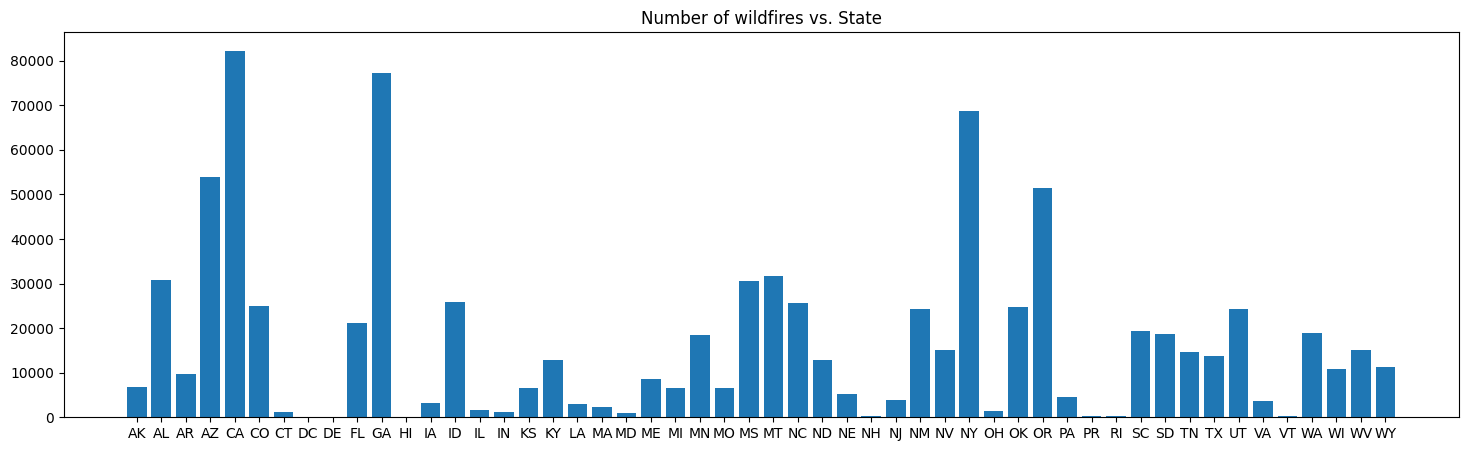

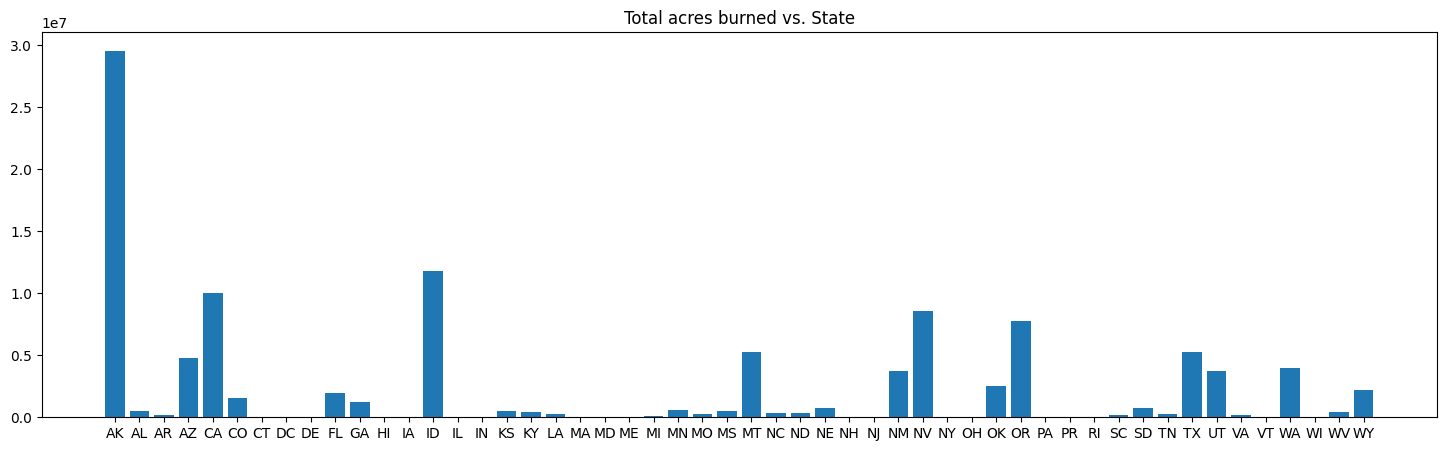

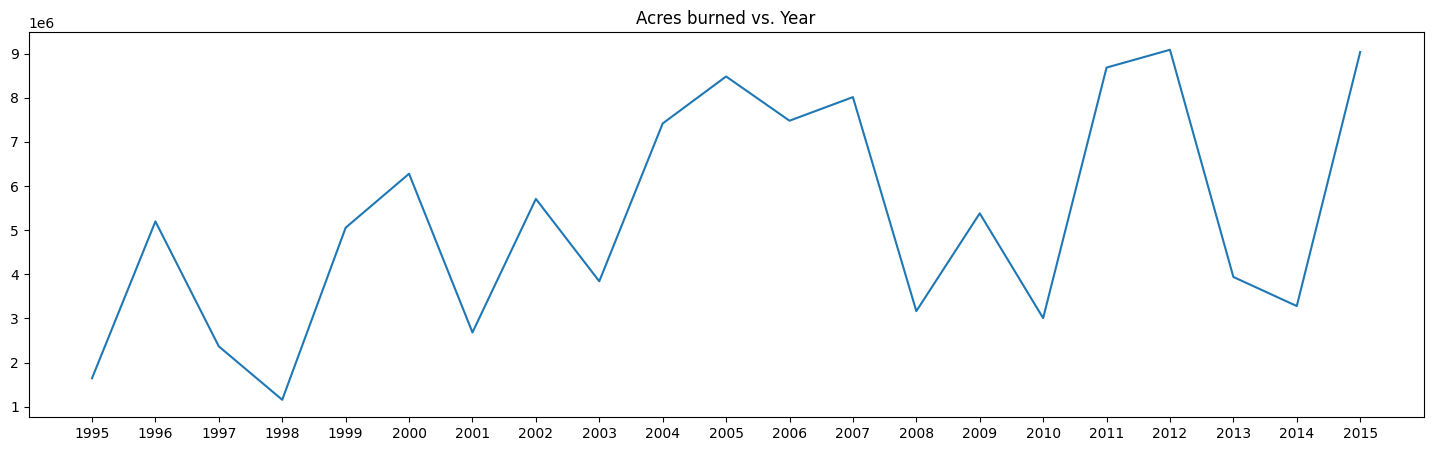

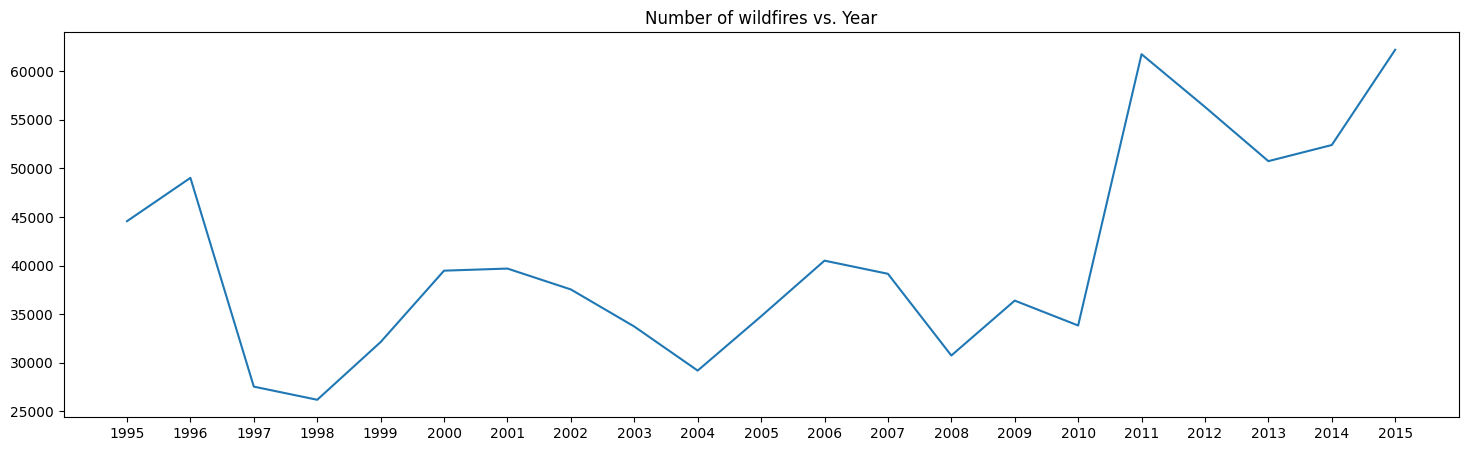

In [26]:
# Get a list of each state's 2 character code including Puerto Rico (PR)
states = fire_data['STATE'].unique()
# making sure both the states list and the fire_data dataframe are in the same sorted order
states.sort()
fire_data.sort_values('STATE', ascending=True, inplace=True)

# Plot Number of wildfires vs. State
plt.figure(figsize=(18, 5))
plt.bar(states, fire_data.groupby('STATE').count()['start_date'])
plt.title('Number of wildfires vs. State')

# Plot Total acres burned vs. State
plt.figure(figsize=(18, 5))
plt.bar(states, fire_data.groupby('STATE')['FIRE_SIZE'].sum())
plt.title('Total acres burned vs. State')

fire_data.sort_values('start_year', ascending=True, inplace=True)
years = fire_data['start_year'].unique()
years.sort()

# Plot Acres burned vs. Year
plt.figure(figsize=(18, 5))
plt.plot(years, fire_data.groupby('start_year')['FIRE_SIZE'].sum())
plt.xticks(years)
plt.title('Acres burned vs. Year')

# Plot Number of wildfires vs. Year
plt.figure(figsize=(18, 5))
plt.plot(years, fire_data.groupby('start_year')['FIRE_SIZE'].count())
plt.xticks(years)
plt.title('Number of wildfires vs. Year')

The first graph says that the state that burned wildfires between 1995 and 2015 is California. This makes sense with sources such as [kin.com](https://www.kin.com/blog/what-states-have-wildfires/), which indicates that Calfornia is known for having a lot of wildfires.

The second graph shows that Alaska has the most amount of acres burned between 1995 and 2015. This data agrees with data on [iii.org](https://www.iii.org/fact-statistic/facts-statistics-wildfires), which indicates that Alaska had the highest number of acres burned.

Note that both of these sources may slightly inaccurate because wildfire size and location vary drastically by year. The next two graphs alone depict how much wildfire count and coverage vary by year. Since our cross-references are only data points for single years, and not over a 20 year aggregate like our data, it makes sense that the references do not line up perfectly. Regardless, there is still correlations between our data and external sources, so this is a good indication that we are analyzing and extracting our data correctly.

The last two graphs above depict acres burned and number of wildfires burned over the years. As we can see, the data is very sporadic. This could indicate that there are many features playing into whether a wildfire occurs. However, it does appear that there is a slight upward trend in both the number of wildfires and their total coverage.

Now let's plot the same number of wildfires by state and total coverage by state graphs again, but this time we'll separate the data by spans of five years. That is, there will be 4 sets of graphs, two graphs for each year span 1995 - 1999, 2000 - 2004, 2005 - 2009, 2010 - 2015.

/var/folders/vm/zh5825t90lvgpttsn_nhzqd80000gn/T/ipykernel_38846/3610976601.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, data in fire_data.groupby('bins'):


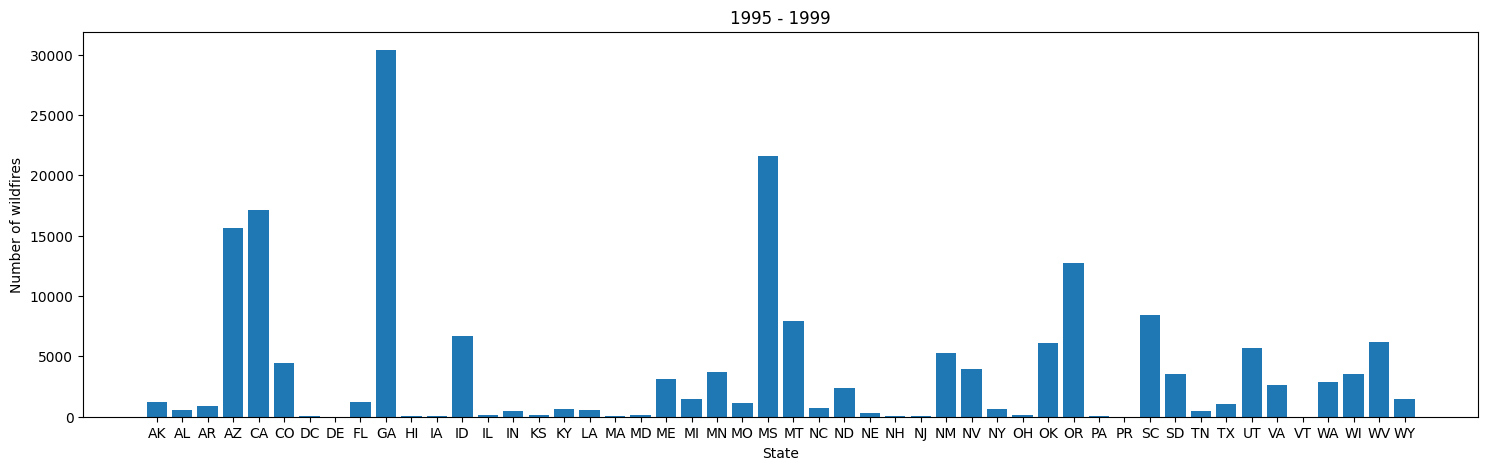

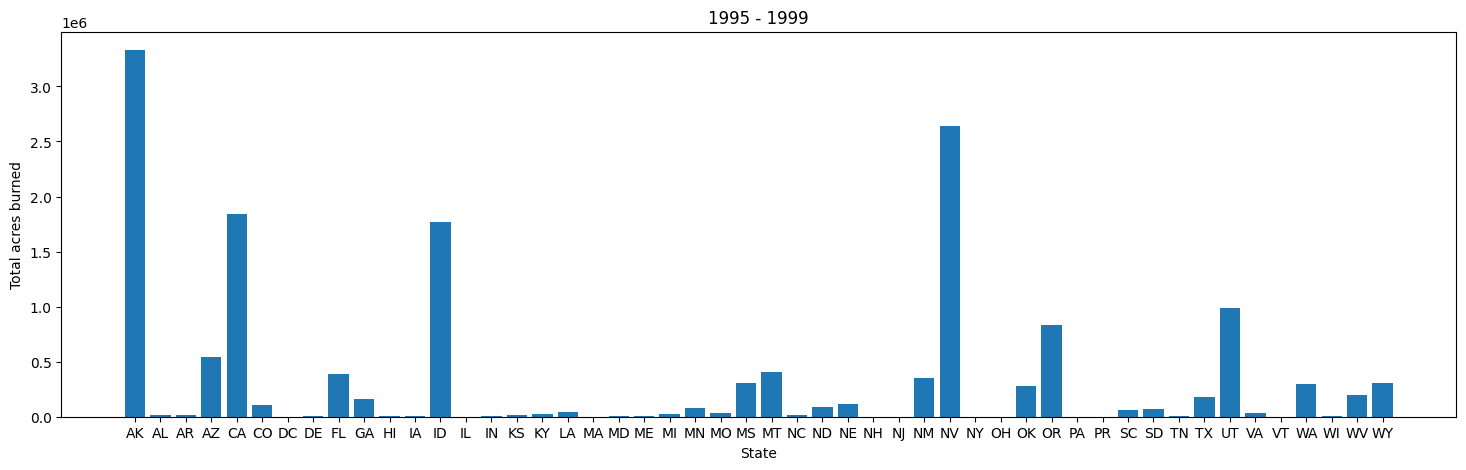

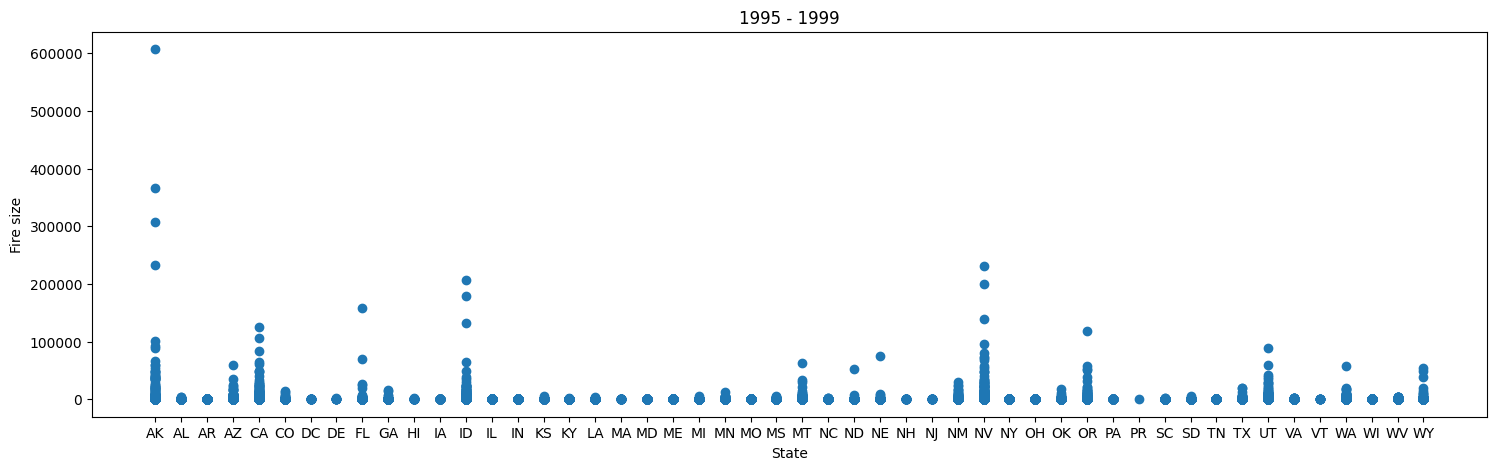

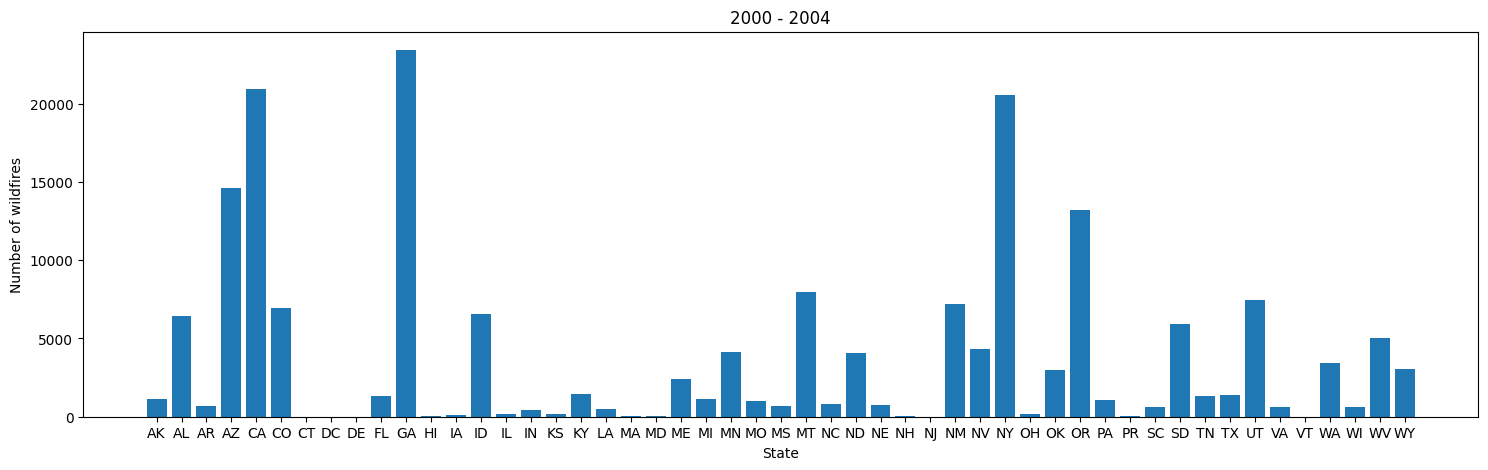

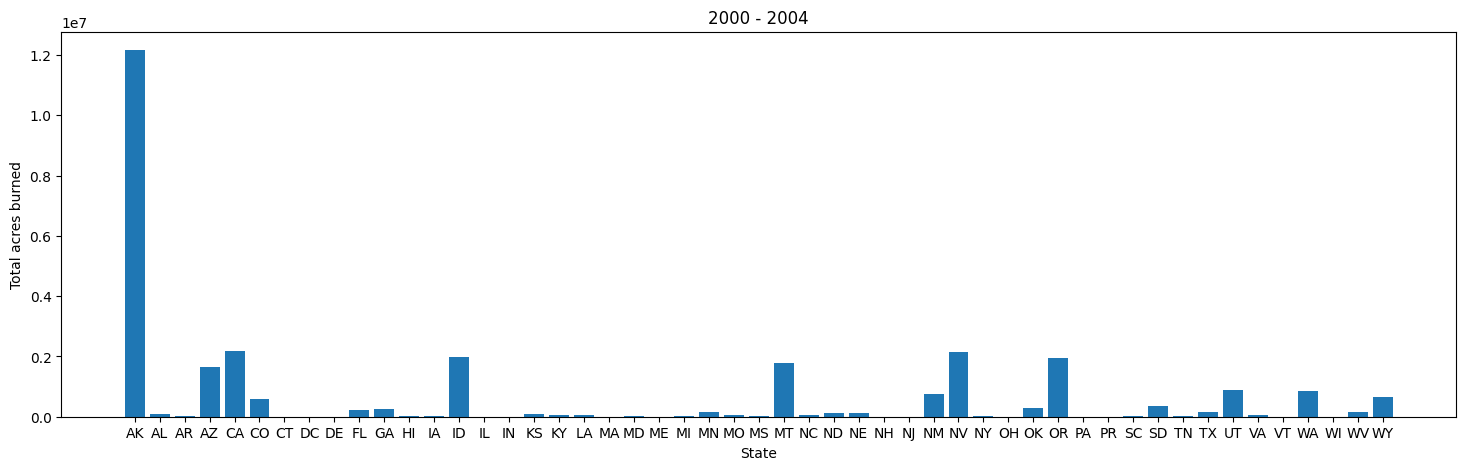

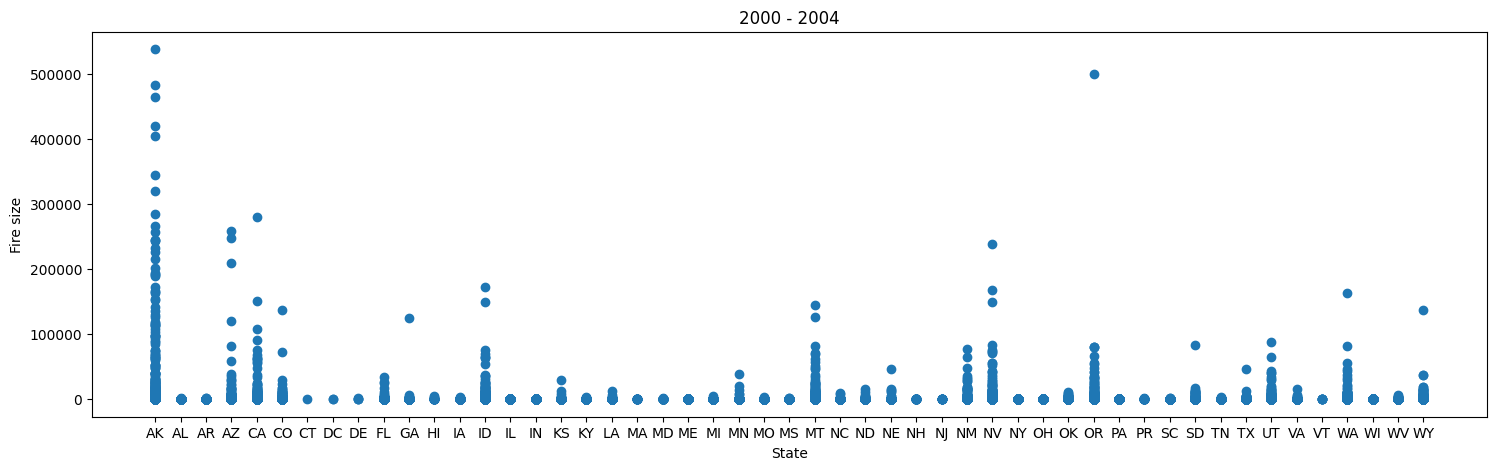

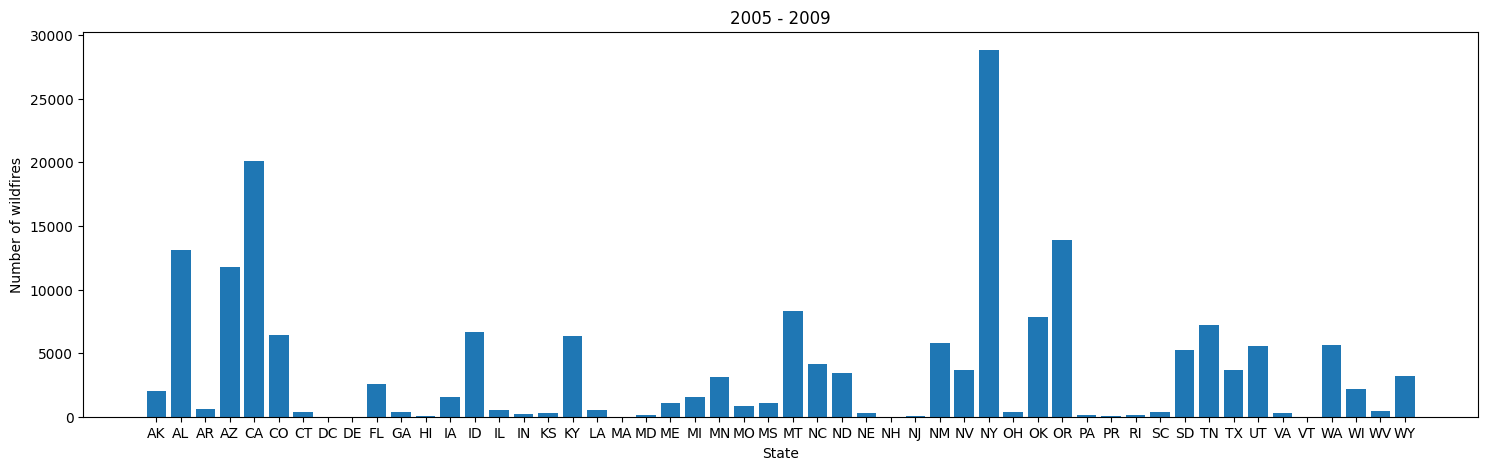

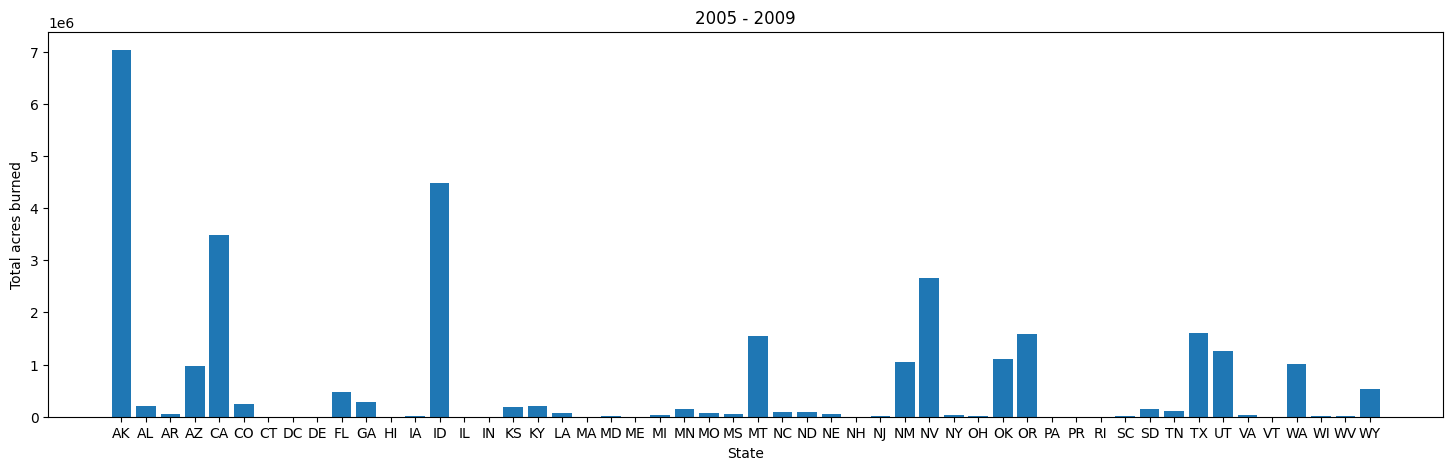

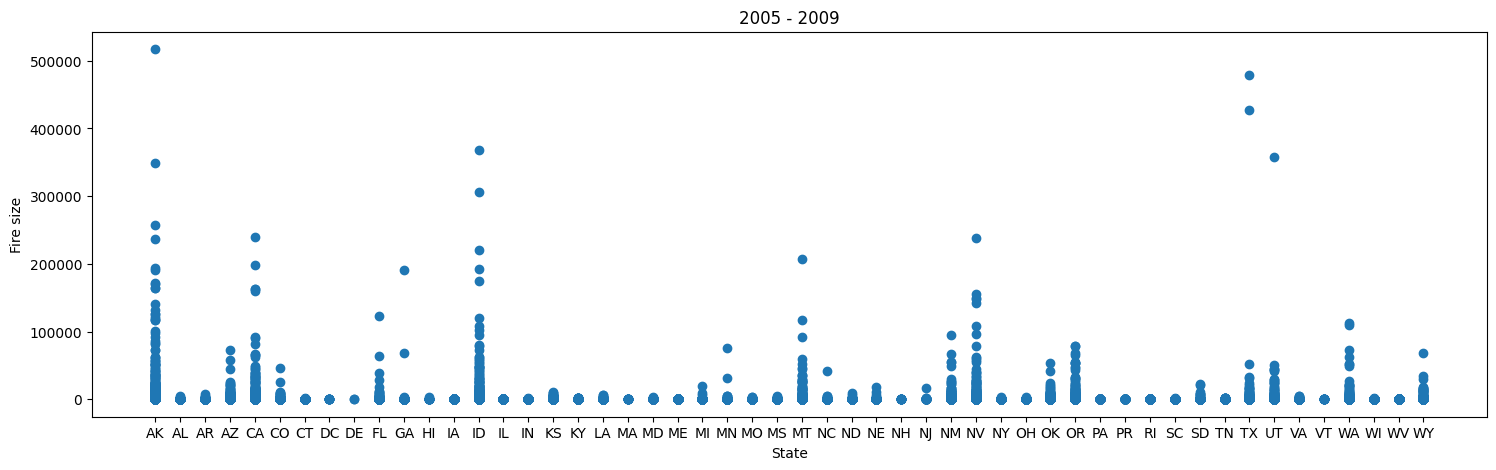

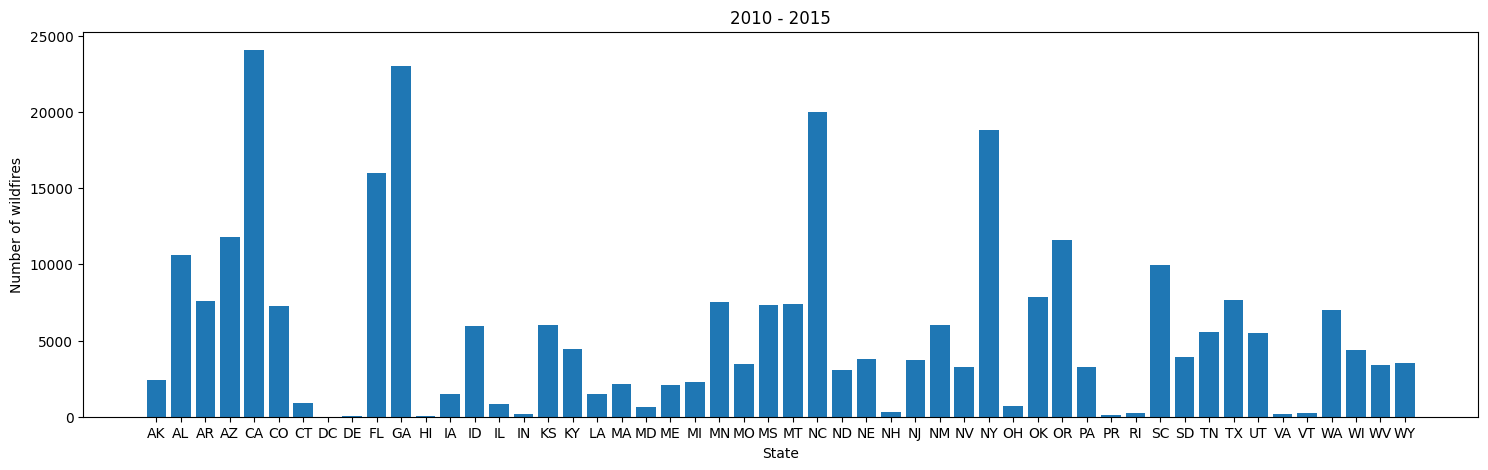

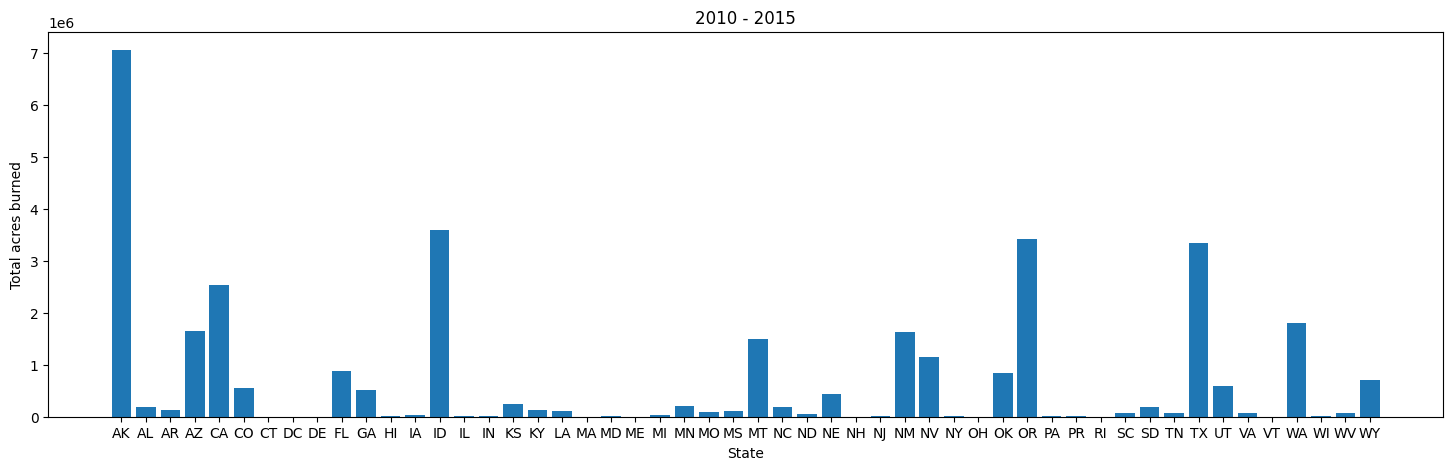

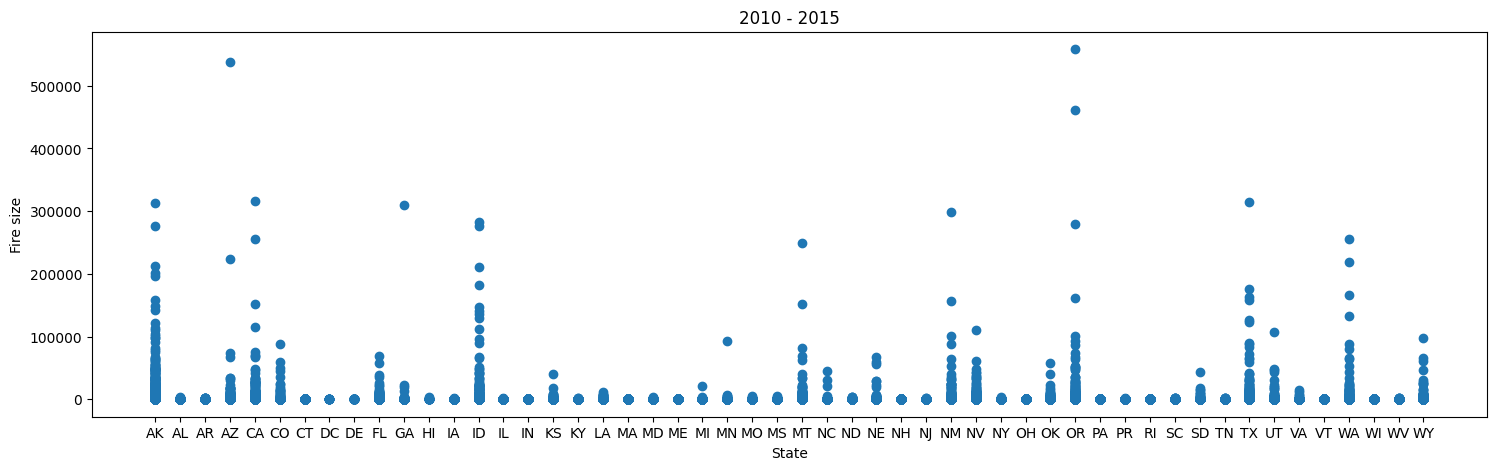

In [27]:
# loop runs over data for each year interval: 1995 - 1999, 2000 - 2004, 2005 - 2009, 2010 - 2015
# plotting each graph for each individual time integral
for name, data in fire_data.groupby('bins'):
    states = data['STATE'].unique()
    states.sort()
    data.sort_values('STATE', ascending=True, inplace=True)

    # plots a bar graph of the number of wild fires by state
    plt.figure(figsize=(18, 5))
    # gets the count of the number of wild fires
    plt.bar(states, data.groupby('STATE')['FIRE_SIZE'].count())
    plt.title(name)
    plt.ylabel('Number of wildfires')
    plt.xlabel('State')

    # plots a bar graph of the number of acres burned by wildfires (the size of the fire) by state 
    plt.figure(figsize=(18, 5))
    # gets the sum of all of the wildfires for a given state 
    plt.bar(states, data.groupby('STATE')['FIRE_SIZE'].sum())
    plt.title(name)
    plt.ylabel('Total acres burned')
    plt.xlabel('State')

    # plots a scatter plot of all of the fires for a state and their acres burned (fire size)
    plt.figure(figsize=(18, 5))
    plt.scatter(data=data, x='STATE', y='FIRE_SIZE')
    plt.title(name)
    plt.ylabel('Fire size')
    plt.xlabel('State')

As we can see, wildfire data by state is also very sporadic. As time varies, both the number of wildfires and acres burned can change by state drastically.

Notice that the scatter plot of the fire size is used so we can see where outliers are. The majority of the fire data points towards the bottom indicate that mainly there are a lot of smaller fires, and occasionally there is a really huge fire.

We are also interested in visualizing which months have the most wildfire occurrences, and during which months, do most acres get burned in.

Text(0.5, 1.0, 'Number of wildfires vs. Month (1995 - 2015)')

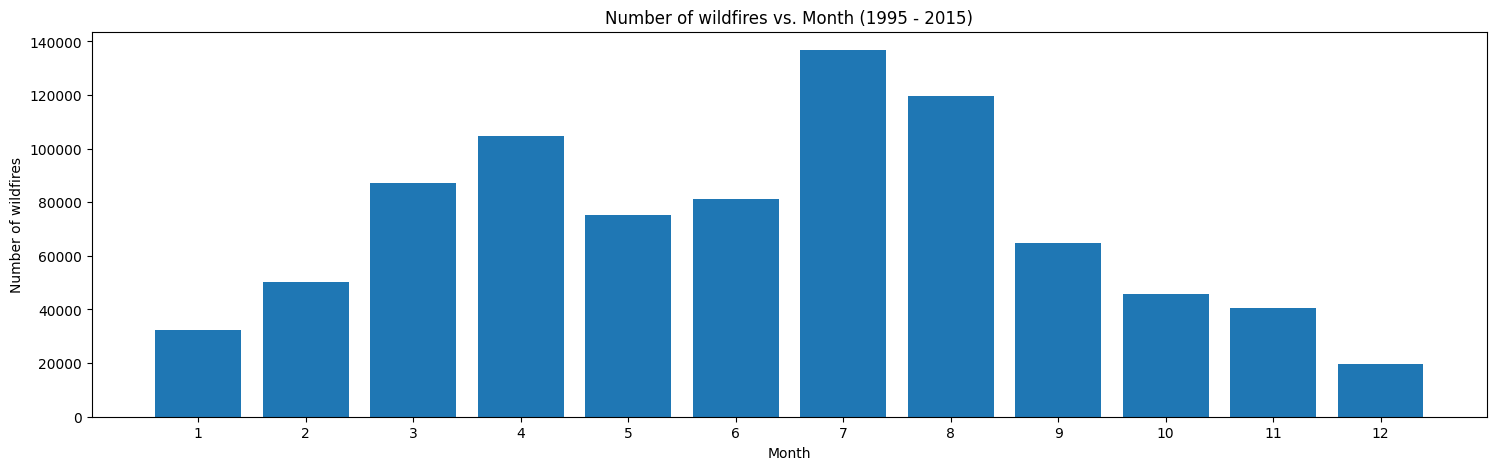

In [28]:
count = []
months = []
# now looping over all of the months in the dataset
# counting and storing the number of wildfires during that month as well as the month's name
for name, data in fire_data.groupby('start_month'):
    months.append(name)
    count.append(data['start_month'].count())

# plotting a bar graph of number of wildfires by month 
plt.figure(figsize=(18, 5))
plt.bar(months, count)
plt.xticks(list(range(1, 13)))
plt.xlabel('Month')
plt.ylabel('Number of wildfires')
plt.title('Number of wildfires vs. Month (1995 - 2015)')

The graph above is a bit bimodal, where the number of wildfires appear to peak around both April and August.

Text(0.5, 1.0, 'Total acres burned vs. Month (1995 - 2015)')

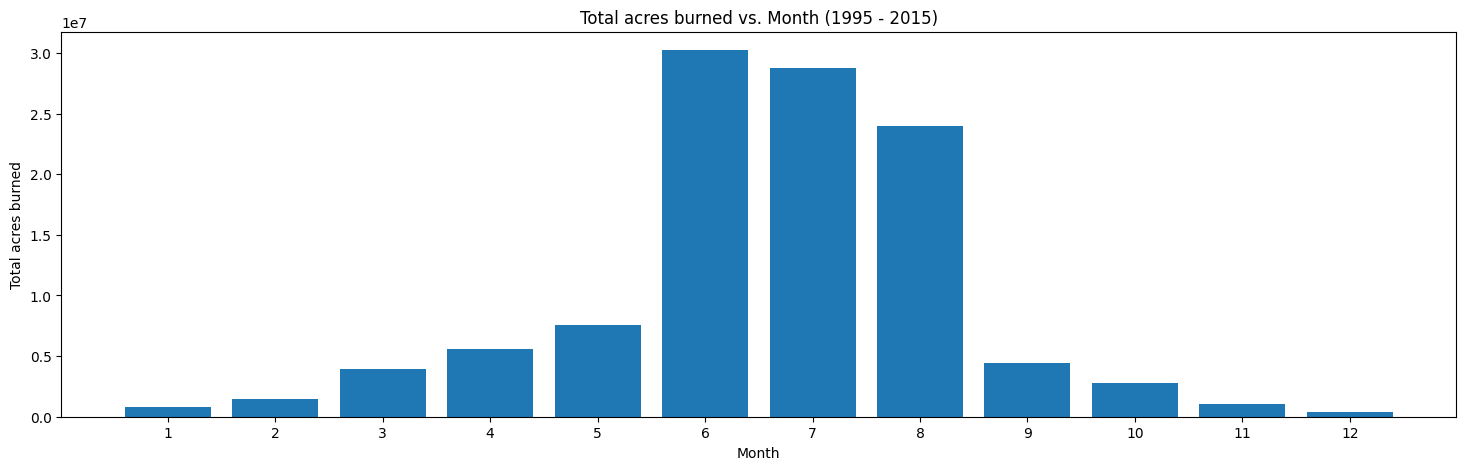

In [29]:
total_area = []
months = []

# now getting the total acreage burned in a month from 1995 - 2015
for name, data in fire_data.groupby('start_month'):
    months.append(name)
    total_area.append(data['FIRE_SIZE'].sum())

# plotting a bar graph of the number of total acres burned by month from 1995 - 2015 
plt.figure(figsize=(18, 5))
plt.bar(months, total_area)
plt.xticks(list(range(1, 13)))
plt.xlabel('Month')
plt.ylabel('Total acres burned')
plt.title('Total acres burned vs. Month (1995 - 2015)')

The graph above indicates that the total acres burned tends to peak around the July-August range.

Now we'll overlay the two graphs from above to see what the differences are.

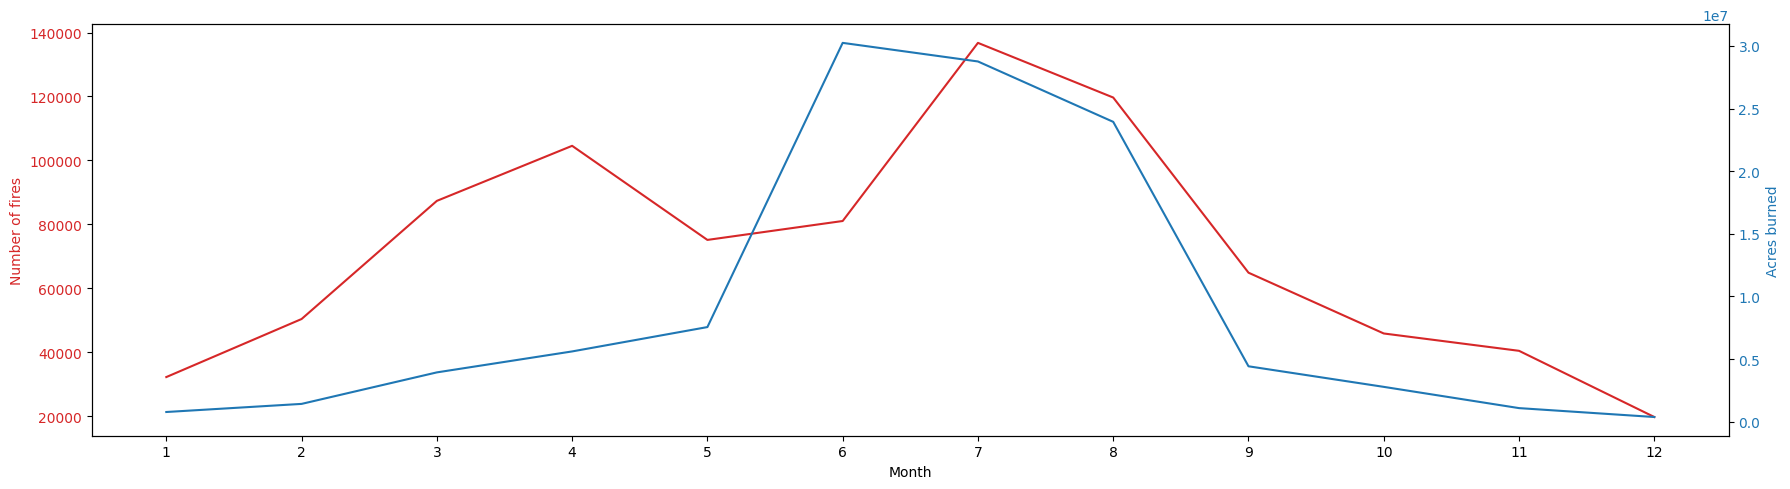

In [30]:
# graphing acres burend by month as well as number of fires by month on the same graph 
# create a subplot so we can graph two lines on the same graph
fig, ax1 = plt.subplots(figsize=(18, 5))
ax1.set_xlabel('Month')
plt.xticks(list(range(1, 13)))

# plot the number of fires on the plot and setting its color to red
color = 'tab:red'
ax1.set_ylabel('Number of fires', color=color)
ax1.plot(months, count, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

# plot the acres burned on the plot and setting its color to blue
color = 'tab:blue'
ax2.set_ylabel('Acres burned', color=color)  # we already handled the x-label with ax1
ax2.plot(months, total_area, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

By overlaying these graphs, we can see that while the number of wildfires peaks at both April and August, the wildfires in April tend to not be very large. The larger wildfires tend to be in July-August range. The bimodal and unimodal graph overlay agrees with the data from [weather.com](https://weather.com/safety/wildfires/news/2021-06-22-most-us-fires-in-2021-through-june-in-10-years).

# Analysis and Machine Learning

At this point we would like to create a model to test whether we can predict attributes about a wildfire, based on other features, such as location, month, year, and cause. We are going to use a number of models with the first being K nearest neighbors.
	
For the KNN model we are going to try to predict fire size given the cause of the fire, month, year, longitude, and latitude. But first, what is KNN ?  KNN is an algorithm that classifies data points based on their closest or “neighboring” data points. We also will be analyzing the entire US and in subsequent models we will look specifically at states of interest. If you want to read more about KNN models look [here](https://www.ibm.com/topics/knn#:~:text=The%20k%2Dnearest%20neighbors%20(KNN,used%20in%20machine%20learning%20today.))


In [31]:
state_codes = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "PR"
]

# Create a dictionary with state codes as keys and increasing integers as values
state_numbers = {state_code: index for index, state_code in enumerate(state_codes)}

# excluding fire_size the feature we want to predict from the other features we use for predictions
X = fire_data.drop('FIRE_SIZE', axis=1)
X = X[[ 'LONGITUDE', 'LATITUDE', 'STAT_CAUSE_CODE', 'start_year', 'start_month' ]].astype(float)
#X = X[[ 'LONGITUDE' ]].astype(float)
display(X)

# the feature we want to predict 
y = fire_data['FIRE_SIZE'].astype(float)
display(y)

# splitting the data in to test and training data sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardizes the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k = 1 # Number of neighbors

# performs KNN 
regressor = KNeighborsRegressor(n_neighbors=k)
regressor.fit(X_train, y_train)

# calculates predicted values based on what KNN trained 
y_pred = regressor.predict(X_test)
# calculates the error in our model 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

,LONGITUDE,LATITUDE,STAT_CAUSE_CODE,start_year,start_month
216236,-116.984200,34.516700,4.0,1995.0,7.0
216206,-115.200800,34.533300,2.0,1995.0,6.0
216205,-117.100900,34.833300,2.0,1995.0,6.0
216204,-117.000900,33.000000,9.0,1995.0,6.0
216180,-115.984200,32.966700,11.0,1995.0,3.0
...,...,...,...,...,...
1846187,-105.435200,44.279100,9.0,2015.0,8.0
1805117,-149.458750,60.906888,13.0,2015.0,5.0
1805112,-150.725000,61.656666,1.0,2015.0,6.0
1805113,-150.586867,61.419033,13.0,2015.0,5.0


216236      2.0
216206      0.5
216205      0.1
216204     10.0
216180      5.0
           ... 
1846187     0.1
1805117     0.1
1805112     0.1
1805113     0.1
1846167     1.0
Name: FIRE_SIZE, Length: 857912, dtype: float64

Mean Squared Error: 18368416.390170857
R^2 Score: -0.7024629561450368


As we can see from the mean squared error (MSE) which is a measure of how accurate our model is, this model did not perform super well since the MSE is extremely large. Let's try to isolate the data to singular states and try out two more different models to see if that makes a difference. 

# Lineaer regression using Gradient Descent
For our linear regression model we will be focusing on the state of california because in recent years it is one of the most wildfire prone states so hopefully it should produce some interesting results. To train the estimation parameters/weights in our linear regression model we will use the gradient descent algorithm. Gradient descent trains the estimation parameters by minimizing the residual loss. The algorithm works by repeatedly iterating through the training data and making changes to the estimation parameters based on the slope of the loss function: going down if loss is increasing. If you would like to read more on gradient descent look [here](https://www.ibm.com/topics/gradient-descent)

LATITUDE      1.750386e-06
LONGITUDE    -6.315204e-05
start_year    7.443618e-08
bias          3.711085e-11
dtype: float64

array([3.44441429e+11, 3.44438830e+11, 3.44436242e+11, 3.44433667e+11,
       3.44431103e+11, 3.44428551e+11, 3.44426011e+11, 3.44423482e+11,
       3.44420965e+11, 3.44418460e+11])

Predicted Values:


1854866    116.641763
1854868    115.950249
1854903    102.173780
1854914    113.759617
1854916    113.168664
              ...    
1824694    110.072494
1820335    112.551184
1823366    112.484948
1823381    112.248105
1823413    110.813590
Length: 5959, dtype: float64

Actual Values:


1854866     0.01
1854868     0.10
1854903     0.25
1854914    53.00
1854916     1.00
           ...  
1824694     0.25
1820335     1.00
1823366     9.01
1823381     0.01
1823413     1.00
Name: FIRE_SIZE, Length: 5959, dtype: float64

MSE: 8347723134.512982


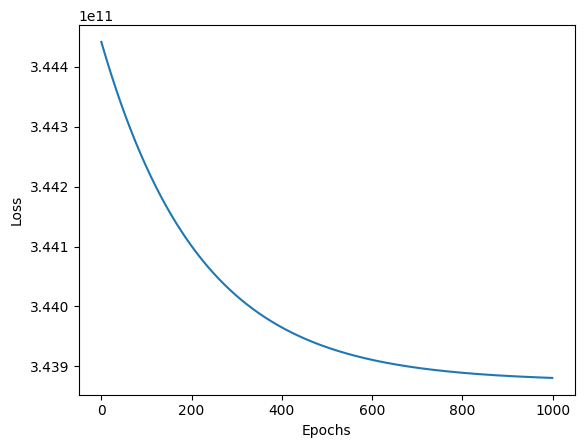

In [32]:
# isolate data to california
data = fire_data[fire_data['STATE'] == 'CA']

# use the data from 2015 as our test dataset to test the model 
test = data[data['start_year'] == 2015]
data = data[data['start_year'] != 2015]

# perform gradient descent 
def grad_descent(X,y,T,alpha):
    m, n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        f[i] = 0.5*np.linalg.norm(X.dot(theta)-y)**2    # adjust loss function 
        g = np.transpose(X).dot(X.dot(theta)-y)
        theta = theta - alpha*g                         # adjust estimation/weight parameters
    return(theta,f)

# With trial and error, we find these values to work well for T and alpha
T = 1000
alpha = 0.00000000000000000001

# Create the X data based off the three variables, and add the bias column of
# ones.
data['LONGITUDE'] = data['LONGITUDE'] ** 3
data['LATITUDE'] = data['LATITUDE'] ** 3

X = data[['LATITUDE', 'LONGITUDE',  'start_year']].astype(float)
X['bias'] = 1

# perform gradient descent to get weights and the final loss function 
theta,loss = grad_descent(X, data['FIRE_SIZE'].astype(float),T,alpha)

display(theta)
display(loss[0:10])



############ LOSS
# calculating our predictions based on the weights gradient descent trained
pred = test['LATITUDE'].astype(float)**3 * theta['LATITUDE'] + \
            test['LONGITUDE'].astype(float)**3 * theta['LONGITUDE'] + \
                test['start_year'].astype(float) * theta['start_year'] + \
                    theta['bias']

print("Predicted Values:")
display(pred)

print("Actual Values:")
display(test['FIRE_SIZE'])

# Calculate the Mean Squared Error
mse = np.sum((test['FIRE_SIZE'].astype(float)-pred)**2) / 5
print("MSE: " + str(mse))

plt.plot(range(T),loss)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

If we look at the trained weights we can see that this model believes that longitude is the most important factor when predicting forest fires as it is at least a magnitude of 10 larger than the other weights. Further we can also observe that the error in the predicted model, the mean squared error, is very large so this method of evaluating wildfires is not great. Let’s try another method!

# Random Forest
Next let’s look at the state of Georgia which also had a significant amount of fires over the years especially in the 2000-2004 timeframe. Let’s also try the random forest algorithm to train our model since the other two models had a high error.  A random forest model works by randomly selecting subsets of features and data samples to create multiple decision trees during training and outputting the mean prediction from all of the individual trees. If you want to read about random forest look [here](https://builtin.com/data-science/random-forest-algorithm)


In [33]:
# Isolate data just from the state of Georgia, and only after 2010
data = fire_data[fire_data['STATE'] == 'GA']
data = data[data['start_year'] > 2010]

# Pick out specific data features we want our model to use
X = data.drop('FIRE_SIZE', axis=1)
X = X[[ 'LONGITUDE', 'LATITUDE', 'STAT_CAUSE_CODE', 'start_year', 'start_month' ]].astype(float)
y = data['FIRE_SIZE'].astype(float)

# Split our data into a training and testing set so we can evaluate the efficacy of our model later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the random forest model on our training data, using a regressor instead of a classifier
regressor = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
regressor.fit(X_train, y_train)

# Use our testing data to generate predicted values of fire size
y_pred = regressor.predict(X_test)
# Calcualte the mean squared error and r-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print the importance weights of the features in our model
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


Mean Squared Error: 31051.98888795203
R^2 Score: -6.262683649122513
                 importance
LATITUDE           0.876710
LONGITUDE          0.110208
start_year         0.008943
start_month        0.002360
STAT_CAUSE_CODE    0.001779


Now we can see how random forest values each feature the model uses to predict. Looking at the feature importance we can see that the random forest model valued latitude which is an interesting departure from the gradient descent algorithm which valued longitude. Though we can see a clear trend that geographical location is the predominant determiner of wildfire acres burned in these models.

# Model Analysis 

We can see that none of the above models work super well in predicting the acreage burned in a wildfire as all of them produce Mean Squared Errors that are very large. Though in every model we can see that geographical data is the most important predictor in wildfire acres burned. This makes sense as location can influence a variety of factors such as temperature, humidity and other aspects of a location's climate. Here is an article that discusses this link [further](https://www.who.int/health-topics/wildfires#tab=tab_1)


# Least Squares Linear Regression
Now let's use least squares regression to determine some relationships between years and both the number of wildfires as well as the total acres burned over the whole US. We will create two separate linear regression models, both with years as the independent variable, but one with number of wildfires per year as our dependent variable, and the other with acres burned per year as our dependent variable. We can use built-in NumPy functions to fit the regression models, and then analyze their efficacy. 


'Number of Wildfires Per Year Regression Slope: 962.777922077922'

'Number of Wildfires Per Year Regression Intercept: -1889516.7813852811'

'Number of Wildfires Per Year Regression  R Squared: 0.3071565927123393'

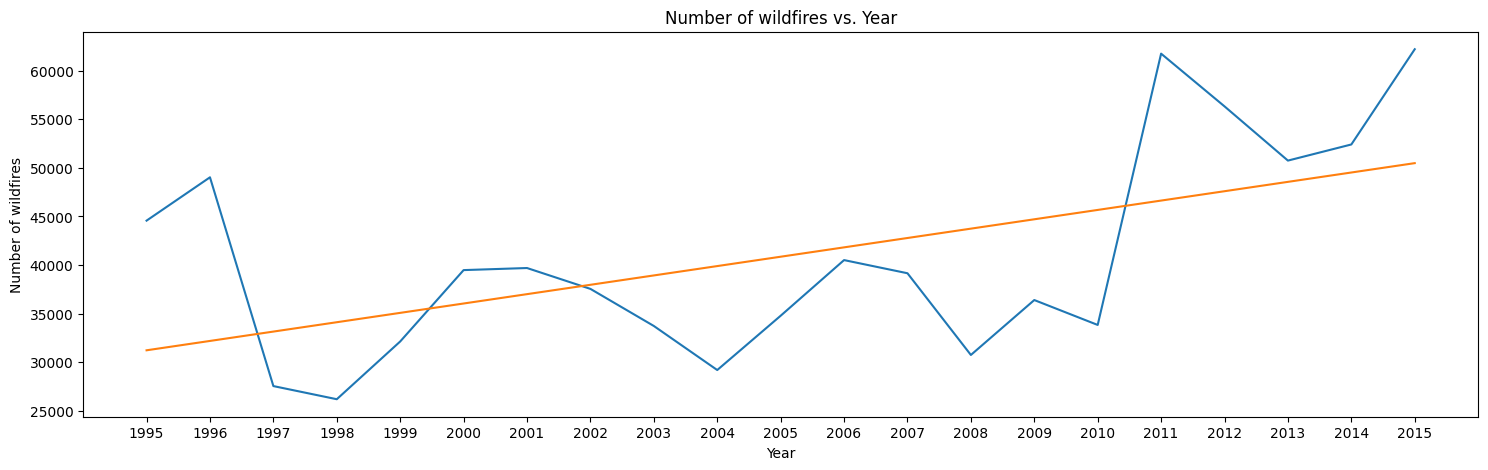

'Acres Burned Per Year Regression Slope: 184102.920883713'

'Acres Burned Per Year Regression Intercept: -363844840.46674466'

'Acres Burned Per Year Regression  R Squared: 0.19837857320110974'

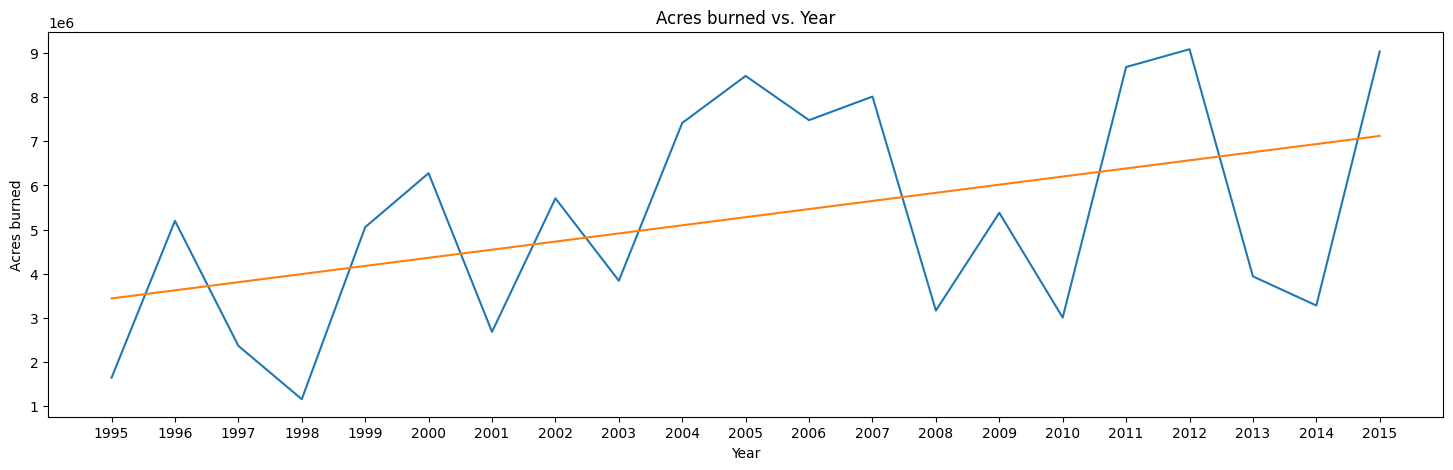

In [34]:


# Plot the number of fires per year 
plt.figure(figsize=(18, 5))
plt.xticks(years)
plt.title('Number of wildfires vs. Year')
plt.plot(years, fire_data.groupby('start_year')['FIRE_SIZE'].count())

# Create a dependant and independent variable to calculate linear regression for
xs = years
ys = fire_data.groupby('start_year')['FIRE_SIZE'].count()

# Use the SciPy library to calculate linear regression for number of fires per year
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, ys)
display("Number of Wildfires Per Year Regression Slope: " + str(slope))
display("Number of Wildfires Per Year Regression Intercept: " + str(intercept))
display("Number of Wildfires Per Year Regression  R Squared: " + str(r_value**2))

# Plot our linear regression least squares line onto the same plot as above with the number of fires per year
plt.plot(xs, intercept + slope * xs)
plt.xlabel('Year')
plt.ylabel('Number of wildfires')
plt.show()


#####################
###
#####################

# Now plot the number of acres burned per year on a separate plot
plt.figure(figsize=(18, 5))
plt.plot(years, fire_data.groupby('start_year')['FIRE_SIZE'].sum())
plt.xticks(years)
plt.title('Acres burned vs. Year')

# Get our dependent and independent variables for linear regression
xs = years
ys = fire_data.groupby('start_year')['FIRE_SIZE'].sum()

# Calculate least squares linear regression using the data chosen above
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, ys)
display("Acres Burned Per Year Regression Slope: " + str(slope))
display("Acres Burned Per Year Regression Intercept: " + str(intercept))
display("Acres Burned Per Year Regression  R Squared: " + str(r_value**2))

# Plot our linear regression line along with the data of acres burned per year
plt.plot(xs, intercept + slope * xs)
plt.xlabel('Year')
plt.ylabel('Acres burned')
plt.show()

As we can see there is a clear upward trend in both graphs. As the year increases both the total acres burned and number of fires also increases, as represented by both of our linear regression models displaying a positive slope. We do see that the r squared correlation coefficient for the number of wildfires per year is significantly higher than that of the r squared value for acres burned per year, suggesting that there is a stronger correlation between the year and the number of fires than there is with number of acres burned per year, however both display a positive correlation coefficient, telling us that there is in fact a positive correlation between the year and both number of fires and number of acres burned. 

#Insight and Policy Decision

In this final step of our data science pipeline, we examine what conclusions we can draw from our data analysis, and determine what further future steps we can take based on the conclusions we derive. 

As we saw from our various machine learning models, there does not seem to be a highly accurate way to predict the size of wildfires based on the data we had in our database. Based on our KNN, regression, and decision tree models we see that geographical location appears to be a relatively strong predictor of fire size, but even so the sizes can vary unpredictably. 

We do see from our linear regression models that both the number of fires and the size of fires appears to be increasing over time, suggesting that fires are getting worse and more common as we approach the modern day. While our current data analysis does not allow for determining the reason for this increase in the number of fires, we would recommend to any policy makers that could examine our data to consider what factors may be causing an increase in wildfires, for example [global warming](https://www.epa.gov/climate-indicators/climate-change-indicators-wildfires#:~:text=Multiple%20studies%20have%20found%20that,wildfire%20frequency%2C%20and%20burned%20area.). 

Another key takeaway from our data is that, since wildfires are extremely difficult to predict, especially in their size, a well designed fire department system across the United States should require fire stations all across America, not leaving any area uncovered, as fires appear capable of appearing anywhere in the country with great, unpredictable risks.  
